In [3]:
!nvidia-smi

Tue Aug 25 11:25:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Write caption to Input captions

#### key words:
*   **Colors**
*   **wings**
*   **head**
*   **belly**
*   **beak**



Cloning into 'Bird-Image-Generator'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 122.85 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/Bird-Image-Generator


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/loca

# **this bird is red with white and has a very short beak**

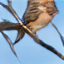

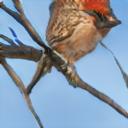

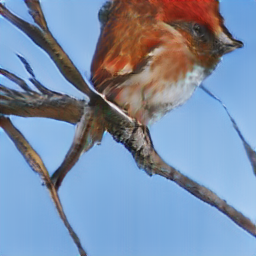

# **the bird has a yellow crown and a black eyering that is round**

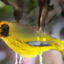

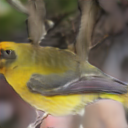

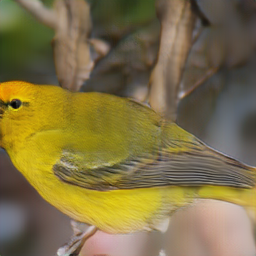

# **this bird has a green crown black primaries and a white belly**

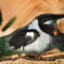

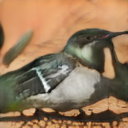

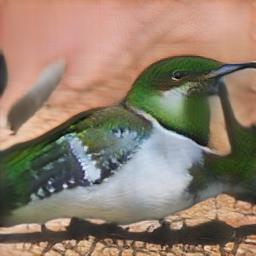

# **this bird has wings that are black and has a white belly**

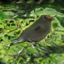

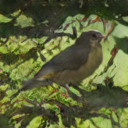

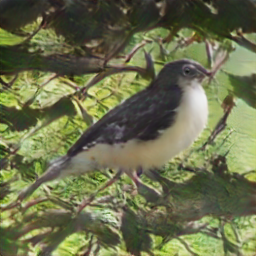

# **this bird has wings that are red and has a yellow belly**

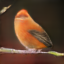

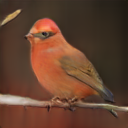

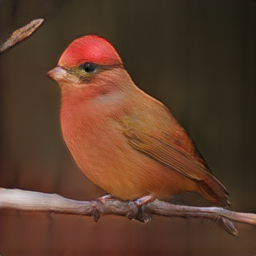

# **this bird has wings that are blue and has a red belly**

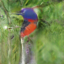

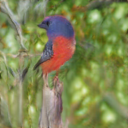

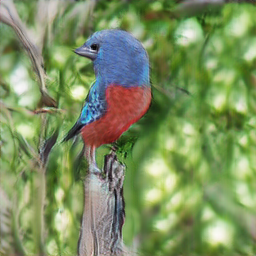

# **this is a small light gray bird with a small head and green crown, nape and some green coloring on its wings**

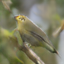

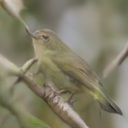

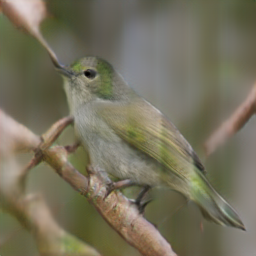

# **his bird is black with white and has a very short beak**

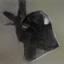

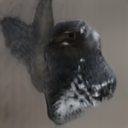

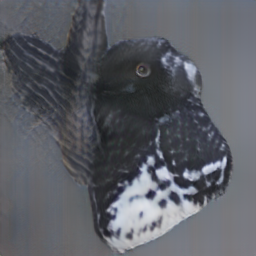

# **this small bird has a deep blue crown, back and rump and a bright white belly**

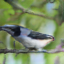

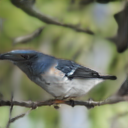

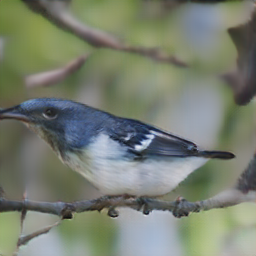

# **this is a blue bird with a white throat, breast, belly and abdomen and a small black pointed beak**

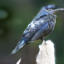

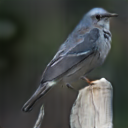

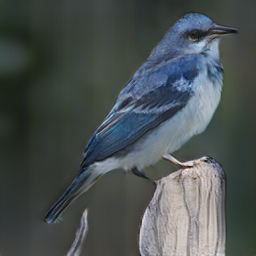

# **yellow abdomen with a black eye without an eye ring and beak quite short**

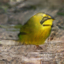

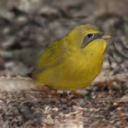

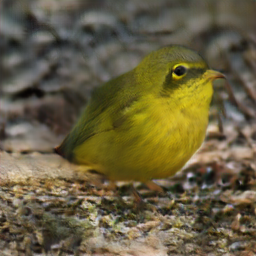

# **this bird is yellow with black on its head and has a very short beak**

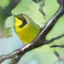

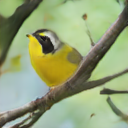

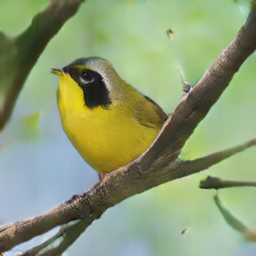

# **this bird has wings that are black and has a white belly**

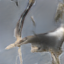

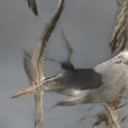

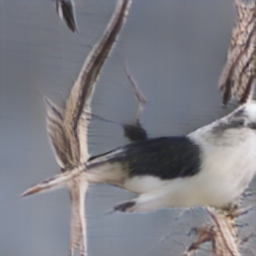

# **this bird has a white belly and breast with a short pointy bill**

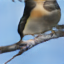

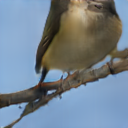

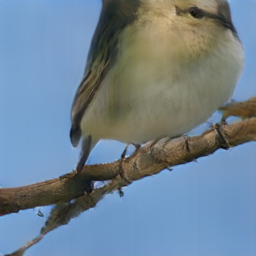

# **this bird is red and white in color with a stubby beak and red eye rings**

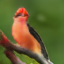

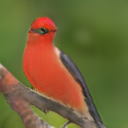

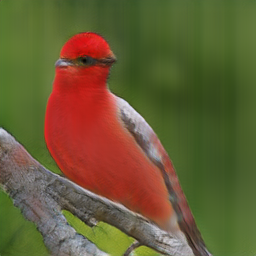

# **a small red and white bird with a small curved beak**

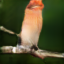

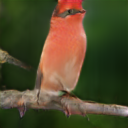

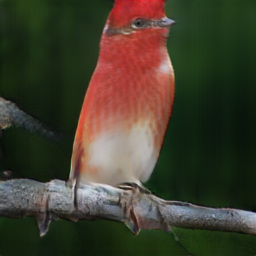

In [6]:
Input_Caption = "This bird has red wings red belly red head short beak"
x=0





import os
os.chdir('/content/')
!rm -r Bird-Image-Generator
!git clone https://github.com/ammarnasr/Bird-Image-Generator.git
os.chdir('/content/Bird-Image-Generator')

bs=16
if x==1:
  with open("example_captions.txt", 'w') as f:
    f.write(Input_Caption)
    bs = 1


the_main()
display_images(bs)

In [4]:
####Configerations Part###
DATA_DIR = "../data/birds"
EMBEDDING_DIM = 256
NET_G = "/content/drive/My Drive/cubModelGAN/netG_epoch_600.pth"
WORDS_NUM = 18
RNN_TYPE = 'LSTM'
NET_E = "text_encoder599.pth"
B_DCGAN = False
GF_DIM = 32
CONDITION_DIM = 100
BRANCH_NUM = 3
R_NUM = 2
Z_DIM = 100
CUDA = True
FONT_MAX = 50
###########


# from easydict import EasyDict as edict
# __C = edict()
# cfg = __C
# __C.GAN = edict()
# cfg.GAN.Z_DIM = 100



###Imports Part###
from IPython.display import Markdown, display
import os
import shutil 
import numpy as np
import pickle
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as Iamge_ipy
from IPython.display import display

############
###utils functions###

def display_images(bs=1):
  filepath = "example_captions.txt"
  with open(filepath, "r") as f:
    sentences = f.read().split('\n')
  for k in range(bs):
    filename0 = '/content/Bird-Image-Generator/netG_epoch_600/example_captions/0_s_%s_g0.png' %k
    filename1 = '/content/Bird-Image-Generator/netG_epoch_600/example_captions/0_s_%s_g1.png' %k
    filename2 = '/content/Bird-Image-Generator/netG_epoch_600/example_captions/0_s_%s_g2.png' %k
    x = Iamge_ipy(filename=filename0) 
    y = Iamge_ipy(filename=filename1) 
    z = Iamge_ipy(filename=filename2) 
    printmd('# **'+sentences[k]+'**')
    display(x, y , z)

def printmd(string):
    display(Markdown(string))


def gen_example(data_dic, n_words):
    # Build and load the generator
    #print ("10. creating an object of RNN_ENCODER")
    text_encoder = RNN_ENCODER(n_words, nhidden=EMBEDDING_DIM)
    #print("15. text_encoder object of RNN_ENCODER created")
    state_dict = torch.load(NET_E, map_location=lambda storage, loc: storage)
    text_encoder.load_state_dict(state_dict)
    #print("16. Loaded weights for text_encoder from:", NET_E)
    #cudaaa text_encoder = text_encoder.cuda()
    text_encoder.eval()
    #print("17. text_encoder moved to gpu and in evaluation mode")

    # the path to save generated images
    if B_DCGAN:
        netG = G_DCGAN()
    else:
        #print("18. creating an object of G_NET (Generator)")
        netG = G_NET()
        #print("47. object of G_NET (netG) 'Three stage Generator created'")
    s_tmp = NET_G[:NET_G.rfind('.pth')]
    model_dir = NET_G

    state_dict = torch.load(model_dir, map_location=lambda storage, loc: storage)
    netG.load_state_dict(state_dict)
    #print("48. Loaded weights for netG from:", model_dir)
    #cudaaa netG.cuda()
    netG.eval()
    #print("49. text_encoder moved to gpu and in evaluation mode")
    for key in data_dic:
        s_tmp = '/content/Bird-Image-Generator/netG_epoch_600'
        save_dir = '%s/%s' % (s_tmp, key)
        mkdir_p(save_dir)
        #print ("50. Created directory with name : ", save_dir)
        captions, cap_lens, sorted_indices = data_dic[key]
        
        #print("51. fetched captions, cap_lens, sorted_indices from the dictionary")

        batch_size = captions.shape[0]
        #print("52. got batch size from caption array (number of sentences in file) as :" ,batch_size)
        nz = Z_DIM
        captions = Variable(torch.from_numpy(captions), volatile=True)
        cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)

        #cudaaa captions = captions.cuda()
        #cudaaa cap_lens = cap_lens.cuda()
        #print("53. Loaded captions to pytorch and moved to cuda")
        for i in range(1):  # 16
            noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
            #cudaaa noise = noise.cuda()
            #print("54. Loaded noise to pytorch and moved to cuda")
            #######################################################
            # (1) Extract text embeddings
            ######################################################
            #print("55. Calling init_hidden of RNN_ENCODER (text_encoder)")
            hidden = text_encoder.init_hidden(batch_size)
            #print("56. finished init_hidden of RNN_ENCODER (text_encoder)")
            # words_embs: batch_size x nef x seq_len
            # sent_emb: batch_size x nef
            #print("57. Calling forward of RNN_ENCODER (text_encoder)")
            words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
            #print("58. finished forward of RNN_ENCODER (text_encoder)")
            mask = (captions == 0)
            #print("59. something to make mask of captions")
            #######################################################
            # (2) Generate fake images
            ######################################################
            noise.data.normal_(0, 1)
            #print ("60. Calling forward of G_NET (netG)")
            fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask)
            #print ("86. finished forward of G_NET (netG)")
            # G attention
            cap_lens_np = cap_lens.cpu().data.numpy()
            for j in range(batch_size):
                save_name = '%s/%d_s_%d' % (save_dir, i, sorted_indices[j])
                #print("87.Saving each image generated of the 16 captions with name: (", save_name,")")
                for k in range(len(fake_imgs)):
                    #print("88. looping through the 3 images from each stage to save (",k+1,"of 3)")
                    im = fake_imgs[k][j].data.cpu().numpy()
                    im = (im + 1.0) * 127.5
                    im = im.astype(np.uint8)
                    #print('89.image number :', k+1 ," with shape: ", im.shape, "moved to cpu as numpy array")
                    im = np.transpose(im, (1, 2, 0))
                    #print('90. image transposed to change to PIL image with shape : ', im.shape)
                    im = Image.fromarray(im)
                    fullpath = '%s_g%d.png' % (save_name, k)
                    im.save(fullpath)
                    #print("91. image saved to path: ", fullpath)

                # for k in range(len(attention_maps)):
                #     if len(fake_imgs) > 1:
                #         im = fake_imgs[k + 1].detach().cpu()
                #     else:
                #         im = fake_imgs[0].detach().cpu()
                #     attn_maps = attention_maps[k]
                #     att_sze = attn_maps.size(2)
                #     img_set, sentences = \
                #         build_super_images2(im[j].unsqueeze(0),
                #                             captions[j].unsqueeze(0),
                #                             [cap_lens_np[j]], wordtoix,
                #                             [attn_maps[j]], att_sze)
                #     if img_set is not None:
                #         im = Image.fromarray(img_set)
                #         fullpath = '%s_a%d.png' % (save_name, k)
                #         im.save(fullpath)

def mkdir_p(path):
    #print("using mkdir_p")
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def upBlock(in_planes, out_planes):
    #print("using upBlock")
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes * 2),
        nn.BatchNorm2d(out_planes * 2),
        GLU())
    return block


def conv1x1(in_planes, out_planes):
    "1x1 convolution with padding"
    #print("using conv1x1")
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                    padding=0, bias=False)


def conv3x3(in_planes, out_planes):
    "3x3 convolution with padding"
    #print("using conv3x3")
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                     padding=1, bias=False)

def describe_tensor (name , tensor):
    #print (name ,": size : " , tensor.size())
    #print (name ,": first element : " , tensor[0])
    #print (name ,": non-zeros : ",tensor.view(-1).nonzero().size())
    name = ""


#####################
###Class of Models###

class RNN_ENCODER(nn.Module):
    def __init__(self,
                ntoken,
                ninput=300,
                drop_prob=0.5,
                nhidden=128,
                nlayers=1,
                bidirectional=True):
        super(RNN_ENCODER, self).__init__()
        self.n_steps = WORDS_NUM
        self.ntoken = ntoken  # size of the dictionary that maps words to unique indexes
        self.ninput = ninput  # size of each embedding vector
        self.drop_prob = drop_prob  # probability of an element to be zeroed
        self.nlayers = nlayers  # Number of recurrent layers
        self.bidirectional = bidirectional
        self.rnn_type = RNN_TYPE
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        # number of features in the hidden state
        self.nhidden = nhidden // self.num_directions

        #print ("11. calling define_module of RNN_ENCODER")
        self.define_module()
        #print ("13. calling init_weights of RNN_ENCODER")
        self.init_weights()

    def define_module(self):
        self.encoder = nn.Embedding(self.ntoken, self.ninput)
        self.drop = nn.Dropout(self.drop_prob)
        if self.rnn_type == 'LSTM':
            # dropout: If non-zero, introduces a dropout layer on
            # the outputs of each RNN layer except the last layer
            self.rnn = nn.LSTM(self.ninput,
                                self.nhidden,
                                self.nlayers,
                                batch_first=True,
                                dropout=self.drop_prob,
                                bidirectional=self.bidirectional)
            #print ("12.finshed define_module of RNN_ENCODER")
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(self.ninput,
                                self.nhidden,
                                self.nlayers,
                                batch_first=True,
                                dropout=self.drop_prob,
                                bidirectional=self.bidirectional)
        else:
            raise NotImplementedError

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        # Do not need to initialize RNN parameters, which have been initialized
        # http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM
        # self.decoder.weight.data.uniform_(-initrange, initrange)
        # self.decoder.bias.data.fill_(0)
        #print ("14. finished init_weights of RNN_ENCODER")

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        if self.rnn_type == 'LSTM':
            return (Variable( weight.new(self.nlayers * self.num_directions, bsz, self.nhidden).zero_()),
                    Variable( weight.new(self.nlayers * self.num_directions, bsz, self.nhidden).zero_()))
        else:
            return Variable(
                weight.new(self.nlayers * self.num_directions, bsz,
                           self.nhidden).zero_())

    def forward(self, captions, cap_lens, hidden, mask=None):
        # input: torch.LongTensor of size batch x n_steps
        # --> emb: batch x n_steps x ninput
        emb = self.drop(self.encoder(captions))
        #print("--------------------------------------")
        describe_tensor("emb" , emb)
        #
        # Returns: a PackedSequence object
        cap_lens = cap_lens.data.tolist()
        emb = pack_padded_sequence(emb, cap_lens, batch_first=True)
        # #hidden and memory (num_layers * num_directions, batch, hidden_size):
        # tensor containing the initial hidden state for each element in batch.
        # #output (batch, seq_len, hidden_size * num_directions)
        # #or a PackedSequence object:
        # tensor containing output features (h_t) from the last layer of RNN
        output, hidden = self.rnn(emb, hidden)
        # PackedSequence object
        # --> (batch, seq_len, hidden_size * num_directions)
        output = pad_packed_sequence(output, batch_first=True)[0]


        
        # output = self.drop(output)
        # --> batch x hidden_size*num_directions x seq_len
        words_emb = output.transpose(1, 2)
        # --> batch x num_directions*hidden_size
        if self.rnn_type == 'LSTM':
            sent_emb = hidden[0].transpose(0, 1).contiguous()
        else:
            sent_emb = hidden.transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nhidden * self.num_directions)

        return words_emb, sent_emb

class CA_NET(nn.Module):
    # some code is modified from vae examples
    # (https://github.com/pytorch/examples/blob/master/vae/main.py)
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = EMBEDDING_DIM
        self.c_dim = CONDITION_DIM
        self.fc = nn.Linear(self.t_dim, self.c_dim * 4, bias=True)
        #print("20. Creating an object of GLU")
        self.relu = GLU()
        #print("21. object of GLU (relu) created")

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.c_dim]
        logvar = x[:, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if CUDA:
            #cudaaa eps = torch.cuda.FloatTensor(std.size()).normal_()
            eps = torch.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        #print("62. Calling encode of CA_NET")
        mu, logvar = self.encode(text_embedding)
        #print("63. finished encode of CA_NET")
        #print("64. Calling reparamatrize of CA_NET")
        c_code = self.reparametrize(mu, logvar)
        #print("65. finished reparamatrize of CA_NET")
        describe_tensor("text_embedding",text_embedding)
        describe_tensor("mu",mu)
        describe_tensor("logvar",logvar)
        describe_tensor("c_code",c_code)
        return c_code, mu, logvar

class GLU(nn.Module):
    def __init__(self):
        super(GLU, self).__init__()
        #print("Using GLU")

    def forward(self, x):
        nc = x.size(1)
        assert nc % 2 == 0, 'channels dont divide 2!'
        nc = int(nc / 2)
        return x[:, :nc] * F.sigmoid(x[:, nc:])

class INIT_STAGE_G(nn.Module):
    def __init__(self, ngf, ncf):
        super(INIT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        self.in_dim = Z_DIM + ncf  # cfg.TEXT.EMBEDDING_DIM
        #print("24. calling define module of INIT_STAGE_G ")
        self.define_module()

    def define_module(self):
        nz, ngf = self.in_dim, self.gf_dim
        self.fc = nn.Sequential(
            nn.Linear(nz, ngf * 4 * 4 * 2, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4 * 2),
            GLU())
        #print("25.Creating 4 upBlock Layers (upBlock: Sequential of: nn.Upsample, conv3x3, nn.BatchNorm2d, GLU)")
        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        self.upsample4 = upBlock(ngf // 8, ngf // 16)
        #print("26.upsample1, upsample2, upsample3 and upsample4 careted ")
        #print("27. finished define module of INIT_STAGE_G")

    def forward(self, z_code, c_code):
        """
        :param z_code: batch x cfg.GAN.Z_DIM
        :param c_code: batch x cfg.TEXT.EMBEDDING_DIM
        :return: batch x ngf/16 x 64 x 64
        """
        c_z_code = torch.cat((c_code, z_code), 1)
        # state size ngf x 4 x 4
        out_code = self.fc(c_z_code)
        out_code = out_code.view(-1, self.gf_dim, 4, 4)
        # state size ngf/3 x 8 x 8
        out_code = self.upsample1(out_code)
        # state size ngf/4 x 16 x 16
        out_code = self.upsample2(out_code)
        # state size ngf/8 x 32 x 32
        out_code32 = self.upsample3(out_code)
        # state size ngf/16 x 64 x 64
        out_code64 = self.upsample4(out_code32)

        return out_code64

class GET_IMAGE_G(nn.Module):
    def __init__(self, ngf):
        super(GET_IMAGE_G, self).__init__()
        self.gf_dim = ngf
        self.img = nn.Sequential(
            conv3x3(ngf, 3),
            nn.Tanh()
        )

    def forward(self, h_code):
        out_img = self.img(h_code)
        return out_img

class GlobalAttentionGeneral(nn.Module):
    def __init__(self, idf, cdf):
        super(GlobalAttentionGeneral, self).__init__()
        #print("34. make conv_context of conv1x1")
        self.conv_context = conv1x1(cdf, idf)
        self.sm = nn.Softmax()
        self.mask = None

    def applyMask(self, mask):
        self.mask = mask  # batch x sourceL

    def forward(self, input, context):
        """
            input: batch x idf x ih x iw (queryL=ihxiw)
            context: batch x cdf x sourceL
        """
        ih, iw = input.size(2), input.size(3)
        queryL = ih * iw
        batch_size, sourceL = context.size(0), context.size(2)

        # --> batch x queryL x idf
        target = input.view(batch_size, -1, queryL)
        targetT = torch.transpose(target, 1, 2).contiguous()
        # batch x cdf x sourceL --> batch x cdf x sourceL x 1
        sourceT = context.unsqueeze(3)
        # --> batch x idf x sourceL
        sourceT = self.conv_context(sourceT).squeeze(3)

        # Get attention
        # (batch x queryL x idf)(batch x idf x sourceL)
        # -->batch x queryL x sourceL
        attn = torch.bmm(targetT, sourceT)
        # --> batch*queryL x sourceL
        attn = attn.view(batch_size*queryL, sourceL)
        if self.mask is not None:
            # batch_size x sourceL --> batch_size*queryL x sourceL
            mask = self.mask.repeat(queryL, 1)
            attn.data.masked_fill_(mask.data, -float('inf'))
        attn = self.sm(attn)  # Eq. (2)
        # --> batch x queryL x sourceL
        attn = attn.view(batch_size, queryL, sourceL)
        # --> batch x sourceL x queryL
        attn = torch.transpose(attn, 1, 2).contiguous()

        # (batch x idf x sourceL)(batch x sourceL x queryL)
        # --> batch x idf x queryL
        weightedContext = torch.bmm(sourceT, attn)
        weightedContext = weightedContext.view(batch_size, -1, ih, iw)
        attn = attn.view(batch_size, -1, ih, iw)

        return weightedContext, attn

class NEXT_STAGE_G(nn.Module):
    def __init__(self, ngf, nef, ncf):
        super(NEXT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        self.ef_dim = nef
        self.cf_dim = ncf
        self.num_residual = R_NUM
        #print("32. calling define_module of NEXT_STAGE_G ")
        self.define_module()
        #print("39. finished define_module of NEXT_STAGE_G")

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(R_NUM):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        #print("33.Creating an object of GlobalAttentionGeneral")
        self.att = GlobalAttentionGeneral(ngf, self.ef_dim)
        #print("35. object of GlobalAttentionGeneral (att) created")
        #print("36. calling _make_layer of NEXT_STAGE_G (R_NUM=2 of resBlocks) ")
        self.residual = self._make_layer(ResBlock, ngf * 2)
        #print("37. finished _make_layer of NEXT_STAGE_G")
        #print("38. Creating 1 upBlock Layer")
        self.upsample = upBlock(ngf * 2, ngf)

    def forward(self, h_code, c_code, word_embs, mask):
        """
            h_code1(query):  batch x idf x ih x iw (queryL=ihxiw)
            word_embs(context): batch x cdf x sourceL (sourceL=seq_len)
            c_code1: batch x idf x queryL
            att1: batch x sourceL x queryL
        """
        #print ("73. Calling applyMask of GlobalAttentionGeneral(att)")
        self.att.applyMask(mask)
        #print ("74. finished applyMask of GlobalAttentionGeneral(att)")
        #print ("75. Calling forward of GlobalAttentionGeneral(att)")
        c_code, att = self.att(h_code, word_embs)
        #print ("76. finished forward of GlobalAttentionGeneral(att)")
        h_c_code = torch.cat((h_code, c_code), 1)
        out_code = self.residual(h_c_code)

        # state size ngf/2 x 2in_size x 2in_size
        out_code = self.upsample(out_code)

        return out_code, att

class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        #print("using ResBlock(Sequential : conv3x3, nn.BatchNorm2d, GLU, conv3x3, nn.BatchNorm2d)")
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num * 2),
            nn.BatchNorm2d(channel_num * 2),
            GLU(),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return out

class G_NET(nn.Module):
    def __init__(self):
        super(G_NET, self).__init__()
        ngf = GF_DIM
        nef = EMBEDDING_DIM
        ncf = CONDITION_DIM
        #print("19.Creating an object CA_NET")
        self.ca_net = CA_NET()
        #print("22.object of CA_NET (ca_net) created")

        if BRANCH_NUM > 0:
            #print("23.Creating an object INIT_STAGE_G (first Generator)")
            self.h_net1 = INIT_STAGE_G(ngf * 16, ncf)
            #print("28. object of INIT_STAGE_G (h_net1) created")
            #print("29. Creating an object of GET_IMAGE_G")
            self.img_net1 = GET_IMAGE_G(ngf)
            #print("30. object of GET_IMAGE_G (img_net1) created")
        # gf x 64 x 64
        if BRANCH_NUM > 1:
            #print("31.Creating an object NEXT_STAGE_G (second Generator)")
            self.h_net2 = NEXT_STAGE_G(ngf, nef, ncf)
            #print("40.object of NEXT_STAGE_G(h_net2) created")
            #print("41. Creating an object of GET_IMAGE_G")
            self.img_net2 = GET_IMAGE_G(ngf)
            #print("42. object of GET_IMAGE_G (img_net2) created")
        if BRANCH_NUM > 2:
            #print("43.Creating an object NEXT_STAGE_G (third Generator)")
            #print("--------------BeginDuplicate--------------")
            self.h_net3 = NEXT_STAGE_G(ngf, nef, ncf)
            #print("---------------EndDuplicate---------------")
            #print("44.object of NEXT_STAGE_G(h_net3) created")
            #print("45. Creating an object of GET_IMAGE_G")
            self.img_net3 = GET_IMAGE_G(ngf)
            #print("46. object of GET_IMAGE_G (img_net3) created")

    def forward(self, z_code, sent_emb, word_embs, mask):
        """
            :param z_code: batch x cfg.GAN.Z_DIM
            :param sent_emb: batch x cfg.TEXT.EMBEDDING_DIM
            :param word_embs: batch x cdf x seq_len
            :param mask: batch x seq_len
            :return:
        """
        describe_tensor("z_code " , z_code)
        describe_tensor(" sent_emb" ,sent_emb )
        describe_tensor("word_embs" ,word_embs )
        describe_tensor("mask " ,mask )
        fake_imgs = []
        att_maps = []
        #print ("61. Calling forward of CA_NET (ca_net)")
        c_code, mu, logvar = self.ca_net(sent_emb)
        #print ("66. finished forward of CA_NET (ca_net)")

        if BRANCH_NUM > 0:
            #print ("67. Calling forward of INIT_STAGE_G (h_net1)")
            h_code1 = self.h_net1(z_code, c_code)
            #print ("68. finished forward of INIT_STAGE_G (h_net1)")
            #print ("69. Calling forward of GET_IMAGE_G (img_net1)")
            fake_img1 = self.img_net1(h_code1)
            #print ("70. finished forward of GET_IMAGE_G (img_net1)")
            fake_imgs.append(fake_img1)
            #print ("71. appended first stage images (fake_imgs1) to the full list (fake_imgs) ")
        if BRANCH_NUM > 1:
            #print ("72. Calling forward of NEXT_STAGE_G (h_net2)")
            h_code2, att1 = self.h_net2(h_code1, c_code, word_embs, mask)
            #print ("77. finshed forward of NEXT_STAGE_G (h_net2)")
            #print ("78. Calling forward of GET_IMAGE_G (img_net2)")
            fake_img2 = self.img_net2(h_code2)
            #print ("79. finished forward of GET_IMAGE_G (img_net2)")
            fake_imgs.append(fake_img2)
            #print ("80. appended second stage images (fake_imgs2) to the full list (fake_imgs) ")
            if att1 is not None:
                att_maps.append(att1)
        if BRANCH_NUM > 2:
            #print ("81. Calling forward of NEXT_STAGE_G (h_net3)")
            #print("--------------BeginDuplicate--------------")
            h_code3, att2 = self.h_net3(h_code2, c_code, word_embs, mask)
            #print("---------------EndDuplicate---------------")
            #print ("82. finshed forward of NEXT_STAGE_G (h_net3)")
            #print ("83. Calling forward of GET_IMAGE_G (img_net3)")
            fake_img3 = self.img_net3(h_code3)
            #print ("84. Calling forward of GET_IMAGE_G (img_net3)")
            fake_imgs.append(fake_img3)
            #print ("85. appended third stage images (fake_imgs3) to the full list (fake_imgs) ")
            if att2 is not None:
                att_maps.append(att2)

        return fake_imgs, att_maps, mu, logvar


def the_main():

  ###Generate Examples###
  #os.chdir('/content/Bird-Image-Generator/')
  print(os.getcwd())
  shutil.rmtree("/content/Bird-Image-Generator/netG_epoch_600")
  #print("0.This where Execution Start")
  filepath = 'captions.pickle'  # Load captions.pickle contain four parts :
  #captions[0] : train_captions, 88550 caption each of different length of words (9-25),each word represented by unique index
  #captions[1] : test_captions , 29330 caption each of different length of words (9-25),each word represented by unique index
  #captions[2] : index to word dictionary that maps 5450 indexes[key] to words[value]
  #captions[3] : word to index dictionary that maps 5450 words[key] to indexes[value]

  with open(filepath, 'rb') as f:
      x = pickle.load(f)
      ixtoword, wordtoix = x[2], x[3]
      del x
      n_words = len(wordtoix)
      #print("1.Opened and Loaded captions.pickle to fetch wordtoix of length : ", n_words)
      filepath = 'example_filenames.txt' #a group of example filenames, 24 names for 24 file, each file with a number of captions

      data_dic = {}  # dictionary used to generate images from captions
      #key : name of file from which we got captions
      #value: [padded-sorted_based_on_length-indexed captions, original length of each(before padding, indexes to order based on length)

  with open(filepath, "r") as f:
      filenames = f.read().split('\n')
      #print("2.Opened and loaded example_filename.txt")
      first_counter = 0
      for name in filenames:
          first_counter += 1
          if name == "example_captions":  #Keep this way until you download the rest of the file captions
              filepath = '%s.txt' % (name)
              with open(filepath, "r") as f:
                  sentences = f.read().split('\n')
                  #print("3.Opened and loaded example_captions.txt(",first_counter,") in loop of all names of filename")
                  # split your text file of 16 captions to a list of 16 string entries
                  captions = []
                  cap_lens = []
                  second_counter = 0
                  for sent in sentences:
                      second_counter += 1
                      sent = sent.replace("\ufffd\ufffd", " ")
                      tokenizer = RegexpTokenizer(r'\w+')
                      tokens = tokenizer.tokenize(sent.lower())
                      #convert a single sentence(string) to list of tokens(words)=>result in a list of string entries that are word that make up the original sentence(caption)
                      if second_counter == 0 :
                        second_counter = 0
                        #print("4.Tokenized a sentence from example file in filenames (", second_counter,")" )
                      rev = []
                      third_counter = 0
                      for t in tokens:
                          third_counter += 1
                          t = t.encode('ascii', 'ignore').decode('ascii')
                          rev.append(wordtoix[t])
                          if third_counter == 0 :
                            third_counter = 0
                            #print ("5.append converted token to new list(",third_counter,")")
                              #convert the list of words to a list crosspending indexes
                      captions.append(rev)  # all captions in the file
                      cap_lens.append(len(rev))
                      if second_counter == 0:
                        second_counter = 0
                        #print("6.append converted sentence to list of captions (",second_counter,")")
                      # the length(number of words/tokens) in each caption
              max_len = np.max(cap_lens)  # used to pad shorter captions
              sorted_indices = np.argsort(cap_lens)[::-1] # Returns the indices that would sort the array of lengths.
              cap_lens = np.asarray(cap_lens)
              cap_lens = cap_lens[sorted_indices]# sort the array of lengths using the sotring indices
              cap_array = np.zeros((len(captions), max_len), dtype='int64')  #placeholder for the padded sorted array caption
              for i in range(len(captions)):
                  idx = sorted_indices[i]
                  cap = captions[idx]
                  c_len = len(cap)
                  cap_array[i, :c_len] = cap
              #print("7.created padded sorted array of caption cap_array (", first_counter,")")
              key = name[(name.rfind('/') + 1):]
              data_dic[key] = [cap_array, cap_lens, sorted_indices]
              #print("8. created data_dic of cap_array , cap_lens & sorted_indices (", first_counter,")")


  #print("9. Calling gen_example(data_dic) ")
  gen_example(data_dic ,n_words )




